In [1]:
import time
import statistics
import serial
import serial.tools.list_ports
import ipywidgets as widgets
import ipysheet
import matplotlib.pyplot as plt 

%matplotlib widget
plt.rcParams['animation.html']='jshtml'
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
com_ports=serial.tools.list_ports.comports()

com_port=widgets.Dropdown(
    options=[p.device for p in com_ports if "USB" in p.device or "ACM" in p.device or "COM" in p.device],
    description='Virtual serial device:',
    disabled=False
)
com_port.style.description_width='150px'
display(com_port)

Dropdown(description='Virtual serial device:', options=('/dev/ttyACM0',), style=DescriptionStyle(description_w…

In [3]:
arduino_connect_button = widgets.Button(
    description='Connect microcontroller',
    disabled=False,
    button_style='', 
    tooltip='Start Arduino connection',
    icon='plug' 
)
output = widgets.Output(layout={'border': '2px solid black'})

arduino=None
def connect_arduino(b):
    global arduino
    arduino=serial.Serial(com_port.value, baudrate=115200, timeout=1)
    test=2
    with output:
        print("Arduino connected")

arduino_connect_button.on_click(connect_arduino)
display(arduino_connect_button,output)


Button(description='Connect microcontroller', icon='plug', style=ButtonStyle(), tooltip='Start Arduino connect…

Output(layout=Layout(border_bottom='2px solid black', border_left='2px solid black', border_right='2px solid b…

In [4]:
handshake_button = widgets.Button(
    description='Handshake',
    disabled=False,
    button_style='', 
    tooltip='Microcontroller handshake',
    icon='handshake'
)
handshake_output = widgets.Output(layout={'border': '2px solid black'})
handshake_output.clear_output()

def handshake_arduino(sleep_time=1):

    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write('h'.encode())
    
    while (arduino.in_waiting < 0):
        pass
    
    response= arduino.read_until()
    arduino.timeout = timeout
    with handshake_output:
        
        print(response.decode().strip())
        
handshake_button.on_click(handshake_arduino)
display(handshake_button,handshake_output)


Button(description='Handshake', icon='handshake', style=ButtonStyle(), tooltip='Microcontroller handshake')

Output(layout=Layout(border_bottom='2px solid black', border_left='2px solid black', border_right='2px solid b…

In [38]:
def parse_raw_line(raw_line):
    #raw_line = raw_line.decode()
    """if raw_line[-1] != "\n":
        raise ValueError(
            "Every Arduino data comunication must terminate with a new line char."
        )"""
    data=raw_line.rstrip().split("|")
    
    if len(data)!=2:
        raise ValueError(f"Incorrect data type, received {data}")
    else:
        return int(data[0]),int(data[1])

samples=widgets.Dropdown(
    options=range(1,16),
    description='Samples (number):',
    disabled=False,
)
samples.style.description_width='150px'

integration_time=widgets.Dropdown(
                    options=[13,102,402],
                    value=402,
                    description='Integration time (ms):',
                    disabled=False,
                   
)

available_leds={'red':[800,4000],
                'green':[780,900],
                'blue':[780,850],
               'orange':[780,850]}

leds=widgets.Dropdown(
                    options=['red','green','blue','orange'],
                    value='red',
                    description='Led color',
                    disabled=False,
                   
)


leds.style.description_width='100px'


def handle_led_change(change):

    power_slider.value=available_leds[leds.value][0]
    power_slider.min=available_leds[leds.value][0]
    power_slider.max=available_leds[leds.value][1]
    

leds.observe(handle_led_change, names='value')
integration_time.style.description_width='150px'
measure_output = widgets.Output(layout={'border': '2px solid black'})


power_slider=widgets.IntSlider(
    value=available_leds[leds.value][0],
    min=available_leds[leds.value][0],
    max=available_leds[leds.value][1],
    step=1,
    description='Led Power',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='75%')
)



def send_microcontroller_command(button):
    if isinstance(button, widgets.Button):
        command=buttons[button.description]['command']
    else:
        command=button
    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write(command.encode())
    while (arduino.in_waiting < 0):
        pass
    out_message=''
    response=''
    while True:
        response= arduino.read_until()
        time.sleep(0.1)
        if  response.decode().strip()=='executed':
            break
        out_message+=response.decode().strip()
        if len(response.decode().strip())>0:
            print(response.decode().strip())
        else:
            print("- ")
    arduino.timeout = timeout
    return out_message
    
@measure_output.capture()
def set_led_power(value):
    print(f"Set power to: {power_slider.value}")
    send_microcontroller_command(f"l{power_slider.value}")    


power_button = widgets.Button(
    description='Set power',
    disabled=False,
    button_style='', 
    tooltip='Set led power',
    icon='ruler'
)

power_button.on_click(set_led_power)


TSL2561_CLIPPING_402MS:int=65000
TSL2561_LUX_CHSCALE:int=10
TSL2561_LUX_RATIOSCALE:int =9

def calculateLux(broadband:int,ir:int):
    clipThreshold = TSL2561_CLIPPING_402MS
    chScale = (1 << TSL2561_LUX_CHSCALE)
    channel0:int = (broadband * chScale) >> TSL2561_LUX_CHSCALE
    channel1:int = (ir * chScale) >> TSL2561_LUX_CHSCALE
    ratio:float=0
    lux:float=0
    if (channel0 != 0):
        ratio =channel1/channel0
        
    if ratio>0 and ratio <=0.5:
        lux=0.0304*channel0-0.062*channel0*pow(ratio,1.4)
    elif ratio>0.5 and ratio<=0.61:
        lux=0.0224*channel0-0.031*channel1
    elif ratio>0.61 and ratio <=0.80:
        lux=0.0128*channel0-0.0153*channel1
    elif ratio>0.80 and ratio <=1.30:
        lux=0.00146*channel0-0.00112*channel1
    elif ratio>1.30 and ratio <=3.00:
        lux=0.0
    
    return round(lux,1)


@measure_output.capture()
def get_light_reading(b):
    #n_samples: average over n_samples
    #sensor integration time, defaults to 402ms
    measure_output.clear_output()
    broadband_readings=[]
    ir_readings=[]
    n_samples=samples.value
    int_time=integration_time.value
    reading=0
    send_microcontroller_command('c')
    
    while reading < n_samples:
    #for reading in range(n_samples):
            # send  TSL2561 data reading command
            arduino.write('r'.encode())
            while arduino.in_waiting < 0:
                pass
            # Read serial data from microncontroller serial interface
            
            #raw = arduino.read_until()

            raw=''
            response=''
            while True:
                response= arduino.read_until()
                time.sleep(0.1)
                if  response.decode().strip()=='executed':
                    break
                raw+=response.decode().strip()
                if len(response.decode().strip())>0:
                    print(response.decode().strip())
                else:
                    print("- ")
            try:
                broadband,ir=parse_raw_line(raw)
            except ValueError as e:
                continue
            reading+=1
            broadband_readings.append(broadband)
            ir_readings.append(ir)
            time.sleep(1.5*int_time/1000)
        
    lux_data=calculateLux(int(statistics.mean(broadband_readings)),int(statistics.mean(ir_readings)))
    print(f"Lux {lux_data}")
    return lux_data

measure_button = widgets.Button(
    description='Measure light',
    disabled=False,
    button_style='', 
    tooltip='Get a single illuminance reading',
    icon='ruler'
)

measure_button.on_click(get_light_reading)

selection_lists=widgets.HBox([samples,integration_time,leds,power_slider,power_button])
widgets.VBox([selection_lists,measure_button,measure_output])
    

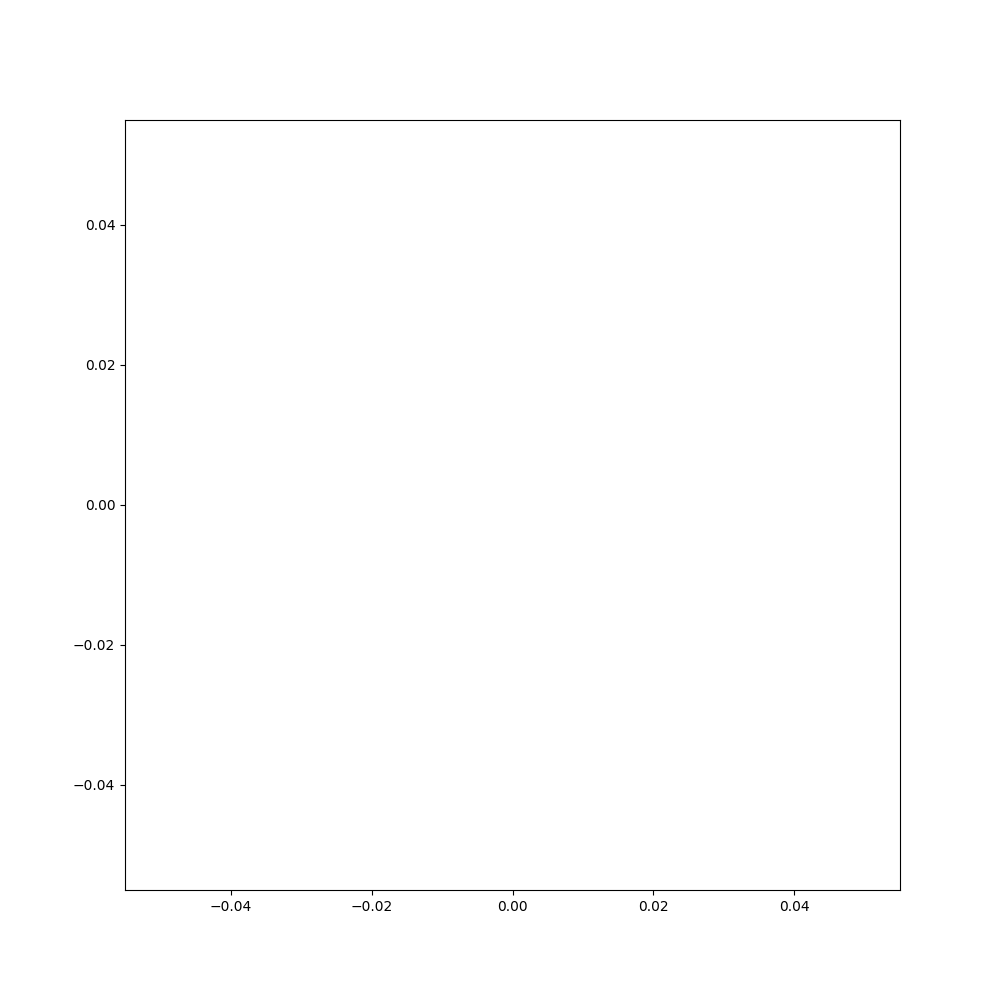

In [33]:
n_rows=10
n_columns=2
sheet_output = widgets.Output(layout={'border': '2px solid black'})
experiment_data=ipysheet.sheet(rows=n_rows, columns=n_columns, column_headers=["Molarity (mol/L)","Illuminance (Lux)"], row_headers=False)
cells=[[ipysheet.cell(i,j,value=0.0) for j in range(n_columns)] for i in range(n_rows)]
cells_data=[[cells[i][j].value for j in range(n_columns)] for i in range(n_rows)]

#create matplotlib figure
regfigure,regax= plt.subplots(figsize=[10,10])
regscatter, = regax.plot([], [], 'bo', label='Illuminance vs Molarity')
#setup reg lines and plot intervals
regline1, = regax.plot([], [], 'r', label='Absorbance calibration curve')

calibration_curve=[0,0]

@sheet_output.capture()
def get_reg_coeff():
    global calibration_curve
    #molarity and illuminance
    molarity_data=[measure[0] for measure in cells_data if measure[0]>=0]
    illuminance_data=[measure[1] for measure in cells_data if measure[1]>=0 ]
    #create  slice objects
    regd1=slice(0,len(molarity_data))
   
    plt.grid()
    plt.xlabel('Molarity (mol/L)')
    plt.ylabel('Illuminance (Lux)')

    regax.set_xlim(min(molarity_data)-1, max(molarity_data)+1)
    regax.set_ylim(min(illuminance_data)-1,max(illuminance_data)+1)
    regax.legend()


    #do the linear reg
    reg1 = LinearRegression()
    x_train1 = np.array(molarity_data[regd1]).reshape(-1, 1)
    y_train1 = np.array(illuminance_data[regd1]).reshape(-1, 1)
    reg1.fit(x_train1,y_train1)
    
    #collect results
    lines_data=[reg1.coef_[0][0],reg1.intercept_[0]]
    calibration_curve=lines_data
    print(lines_data)
    #plot data
    regscatter.set_data(molarity_data,illuminance_data)
    regline1.set_data(molarity_data, reg1.predict(np.array([entry for entry in molarity_data]).reshape(-1, 1)))
    
    return lines_data



@sheet_output.capture()
def measure_light(change):
    illuminance=get_light_reading('test')
    
    cells[change.owner.row_start][change.owner.column_start+1].value=illuminance
    for k in range(2):
        cells_data[change.owner.row_start][k]=cells[change.owner.row_start][k].value
        
    
    get_reg_coeff()
    #plot_data()
    
for i in range(n_rows):
    cells[i][0].observe(measure_light, 'value')
    
widgets.VBox([experiment_data, sheet_output])



In [35]:
lux=widgets.FloatText(
    value=0,
    description='Measured illuminance (Lux)',
    disabled=False
)
lux.style.description_width='190px'

molarity=widgets.Label(value=" Molarity 0")


def handle_lux_change(change):
    
    molarity.value=f"Molarity {(change.new-calibration_curve[1])/calibration_curve[0]}"
    

lux.observe(handle_lux_change, names='value')

widgets.HBox([lux, molarity])
